In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
import requests
import zipfile
import io

In [7]:
# 1. Baixar o conteúdo do arquivo ZIP
url_news = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip'
response = requests.get(url_news)

# 2. Abrir o arquivo ZIP em memória
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# 3. Especificar o caminho EXATO do arquivo CSV dentro do ZIP e carregá-lo com o pandas
# Adicionamos engine='python' para resolver o ParserWarning que também apareceu.
csv_file_path = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'
df_news = pd.read_csv(zip_file.open(csv_file_path), sep=', ', engine='python')

# --- O restante do código permanece igual ---

# Limpeza Inicial
df_news.columns = df_news.columns.str.strip()
df_news = df_news.drop(['url', 'timedelta'], axis=1)

# Aplicando a transformação logarítmica
df_news['shares_log'] = np.log1p(df_news['shares'])

print("Dados carregados e pré-processados com sucesso!")
print("Formato da base:", df_news.shape)


Dados carregados e pré-processados com sucesso!
Formato da base: (39644, 60)


In [8]:
# Separar os atributos (X) da variável alvo (y)
# Usaremos 'shares_log' como nosso alvo e removeremos a coluna 'shares' original.
X = df_news.drop(['shares', 'shares_log'], axis=1)
y = df_news['shares_log']

# Dividir os dados: 80% para treinamento e 20% para teste
# random_state=42 garante que a divisão seja sempre a mesma, para reprodutibilidade.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dados divididos em treinamento e teste:")
print("Formato de X_train:", X_train.shape)
print("Formato de X_test:", X_test.shape)

Dados divididos em treinamento e teste:
Formato de X_train: (31715, 58)
Formato de X_test: (7929, 58)


In [9]:
# 1. Escalonamento dos dados
# Padroniza os atributos para que eles tenham média 0 e desvio padrão 1.
# Isso ajuda o modelo de regressão a funcionar melhor.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # No conjunto de teste, apenas transformamos.

# 2. Treinamento do Modelo Inicial (Baseline)
modelo_regressao_inicial = LinearRegression()
modelo_regressao_inicial.fit(X_train_scaled, y_train)

# 3. Fazendo previsões nos dados de teste
y_pred_log = modelo_regressao_inicial.predict(X_test_scaled)

# 4. Avaliação do Modelo
mse = mean_squared_error(y_test, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_log)

print("--- Resultados do Modelo de Regressão Inicial (Baseline) ---")
print(f"Erro Quadrático Médio (MSE): {mse:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f} (em escala log)")
print(f"Coeficiente de Determinação (R²): {r2:.4f}")

--- Resultados do Modelo de Regressão Inicial (Baseline) ---
Erro Quadrático Médio (MSE): 0.7480
Raiz do Erro Quadrático Médio (RMSE): 0.8649 (em escala log)
Coeficiente de Determinação (R²): 0.1274


In [10]:
# Importar a classe RFE
from sklearn.feature_selection import RFE

# 1. Configuração do RFE
# Vamos usar o mesmo modelo (LinearRegression) para ajudar o RFE a avaliar os atributos.
# O objetivo é reduzir de 58 para os 20 melhores atributos.
estimator = LinearRegression()
seletor_rfe = RFE(estimator, n_features_to_select=20, step=1)

# 2. Treinamento do Seletor RFE
# O RFE é treinado com os dados de treinamento escalonados. Isso pode levar um minuto.
print("Iniciando a seleção de atributos com RFE...")
seletor_rfe = seletor_rfe.fit(X_train_scaled, y_train)
print("Seleção de atributos concluída!")

# 3. Visualizando os atributos que foram selecionados
atributos_selecionados = X.columns[seletor_rfe.support_]
print(f"\nOs {len(atributos_selecionados)} atributos selecionados foram:")
print(list(atributos_selecionados))

# 4. Preparando os dados para o modelo final (usando apenas os atributos escolhidos)
X_train_rfe = seletor_rfe.transform(X_train_scaled)
X_test_rfe = seletor_rfe.transform(X_test_scaled)

# 5. Treinamento do Modelo Final
modelo_regressao_final = LinearRegression()
modelo_regressao_final.fit(X_train_rfe, y_train)

# 6. Fazendo previsões com o modelo final
y_pred_final_log = modelo_regressao_final.predict(X_test_rfe)

# 7. Avaliação do Modelo Final
mse_final = mean_squared_error(y_test, y_pred_final_log)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred_final_log)

print("\n--- Resultados do Modelo de Regressão Final (com RFE) ---")
print(f"Número de atributos utilizados: {X_train_rfe.shape[1]}")
print(f"Erro Quadrático Médio (MSE): {mse_final:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_final:.4f} (em escala log)")
print(f"Coeficiente de Determinação (R²): {r2_final:.4f}")

Iniciando a seleção de atributos com RFE...
Seleção de atributos concluída!

Os 20 atributos selecionados foram:
['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'data_channel_is_entertainment', 'data_channel_is_tech', 'kw_max_min', 'kw_avg_min', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'rate_positive_words', 'rate_negative_words']

--- Resultados do Modelo de Regressão Final (com RFE) ---
Número de atributos utilizados: 20
Erro Quadrático Médio (MSE): 0.7544
Raiz do Erro Quadrático Médio (RMSE): 0.8686 (em escala log)
Coeficiente de Determinação (R²): 0.1199


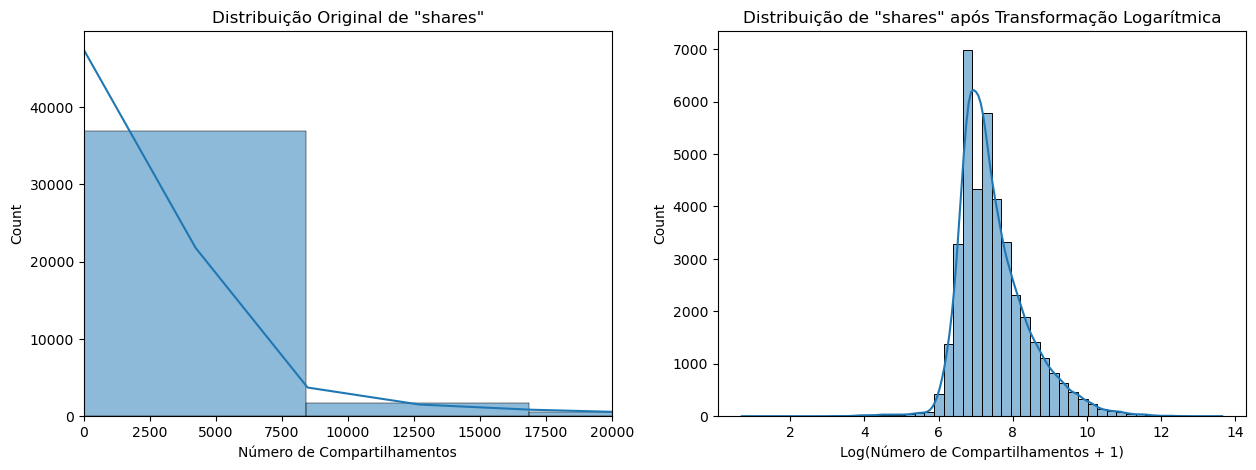

In [11]:
# Célula para gerar os gráficos de distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_news['shares'], bins=100, kde=True, ax=axes[0])
axes[0].set_title('Distribuição Original de "shares"')
axes[0].set_xlabel('Número de Compartilhamentos')
axes[0].set_xlim(0, 20000)

sns.histplot(df_news['shares_log'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribuição de "shares" após Transformação Logarítmica')
axes[1].set_xlabel('Log(Número de Compartilhamentos + 1)')
plt.show()